In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.manifold import TSNE

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


In [2]:
# Load the clean dataset
UNSW_NB15_dataset = pd.read_csv('UNSW_NB15_dataset.csv',index_col=0)
UNSW_NB15_dataset.head()



/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,...,state_INT,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no
0,1390.0,53.0,0.001055,132,164,31,29,0,0,500473.93750,...,0,0,0,0,0,0,0,0,0,0
1,33661.0,1024.0,0.036133,528,304,31,29,0,0,87676.08594,...,0,0,0,0,0,0,0,0,0,0
2,1464.0,53.0,0.001119,146,178,31,29,0,0,521894.53130,...,0,0,0,0,0,0,0,0,0,0
3,3593.0,53.0,0.001209,132,164,31,29,0,0,436724.56250,...,0,0,0,0,0,0,0,0,0,0
4,49664.0,53.0,0.001169,146,178,31,29,0,0,499572.25000,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Select sbytes, sttl, smeansz, ct_dst_sport_ltm, and label columns
unsw_data = UNSW_NB15_dataset.loc[:,['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'Label']]
unsw_data.head()



,sbytes,sttl,smeansz,ct_dst_sport_ltm,Label
0,132,31,66,1,0
1,528,31,132,1,0
2,146,31,73,1,0
3,132,31,66,1,0
4,146,31,73,1,0


We can use 'TSNE' plot to take a look at the dataset by decreasing the dimensionality of the dataset and see whether the normal and attack observations are separable or not. 

In [11]:
def tsne_plot (X, y, title):

    tsne = TSNE(n_components=2, random_state=101)
    
    X_t = tsne.fit_transform(X)

    plt.figure(figsize=(12, 8))
    
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], 
                marker='o', color='g', linewidth='1', alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], 
                marker='o', color='r', linewidth='1', alpha=0.8, label='Attack')
    plt.title(title)
    plt.xlabel('First dimension')
    plt.ylabel('Second dimension')
    plt.legend(loc='best')
    plt.show()


    

In [8]:
from sklearn.model_selection import train_test_split

# Train, validation, test : 98%, 1%, 1% of dataset
X_train, X = train_test_split(unsw_data, test_size = 0.02, random_state = 101)

# We need to train our model on the normal observations only.
X_train = X_train[X_train.Label == 0] # just normal observations
X_train = X_train.drop(['Label'], axis=1) # drop the Label column

y = X['Label'] # save the Label column for the validation and test sets
X = X.drop(['Label'], axis=1) # drop the Label column

# Create the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state = 101)

#transform to ndarray
X_train = X_train.values 
X_val = X_val.values
X_test = X_test.values



In [9]:
print ('train size:', X_train.shape)
print ('validation size:', X_val.shape)
print ('test size:', X_test.shape)


train size: (2174059, 4)
validation size: (25397, 4)
test size: (25398, 4)


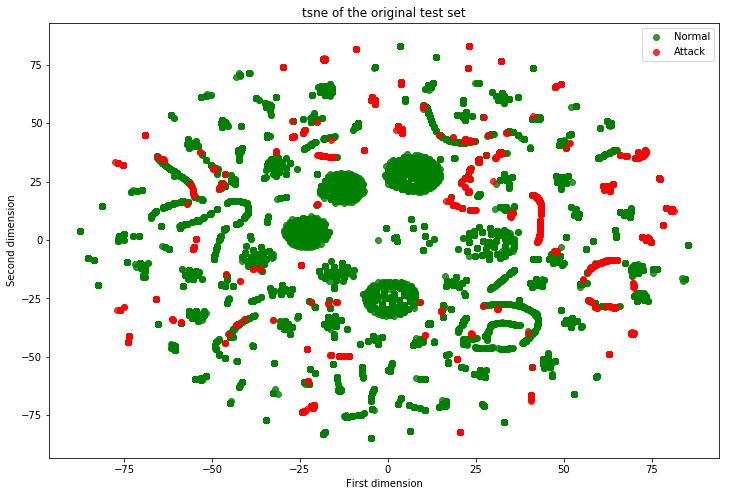

In [12]:
# tsne for the test set
tsne_plot (X_test, y_test, title = 'tsne of the original test set')


Let's repeat the same process, this time for the scaled dataset.

In [14]:
from sklearn.preprocessing import StandardScaler

st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_val = st_sc.transform(X_val)
X_test = st_sc.transform(X_test)



/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


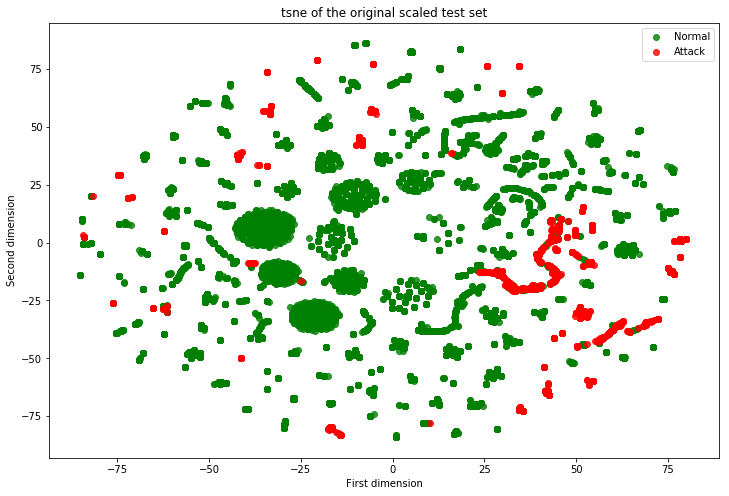

In [15]:
# tsne of the test set after scaling
tsne_plot (X_test, y_test, title = 'tsne of the original scaled test set')


Let's see the result of a very simple classification algorithm on the dataset.

In [34]:
train_x, val_x, train_y, val_y = train_test_split(X_test, y_test, test_size=0.2)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)


accuracy = accuracy_score(val_y, pred_y)
conf_mat = np.array(confusion_matrix(val_y, pred_y, labels=[0,1]))
confusion = pd.DataFrame(conf_mat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])

cl_report = classification_report(val_y, pred_y, target_names=['negative','positive'])

print ("accuracy score: {0:.2f}%".format(accuracy*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (cl_report)





accuracy score: 97.22%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                4345                  78
positive                  63                 594
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.99      0.98      0.98      4423
   positive       0.88      0.90      0.89       657

avg / total       0.97      0.97      0.97      5080



Now we load our autoencoder model which we created before.

In [17]:
from keras.models import load_model
autoencoder = load_model('anomaly_autoencoders_model_v2.h5')


/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/Applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [18]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total para

We use the first four layers in the autoencoder to learn the patterns and latent representation of the input. By creating a new neural net and accessing to the weights of the trained autoencoder model we will obtain the latent representations.

In [19]:
# Latent representation
from keras.models import Sequential

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])


Then we generate the latent representation for the test set and then we can visualize the result with the help of our "tsne_plot" function.

In [20]:
hid_rep = hidden_representation.predict(X_test)



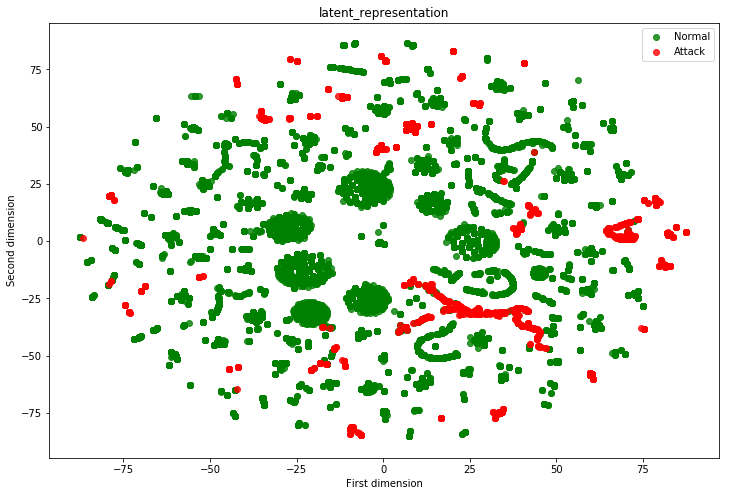

In [21]:
tsne_plot(hid_rep, y_test, title = "latent_representation")


Now we can repeat the logistic regression on the new test set and see the effect of learning latent representations on the accuracy of the model.

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


train_x, val_x, train_y, val_y = train_test_split(hid_rep, y_test, test_size=0.2)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)


accuracy = accuracy_score(val_y, pred_y)
conf_mat = np.array(confusion_matrix(val_y, pred_y, labels=[0,1]))
confusion = pd.DataFrame(conf_mat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])

cl_report = classification_report(val_y, pred_y, target_names=['negative','positive'])

print ("accuracy score: {0:.2f}%".format(accuracy*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (cl_report)





accuracy score: 98.09%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                4369                  68
positive                  29                 614
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.99      0.98      0.99      4437
   positive       0.90      0.95      0.93       643

avg / total       0.98      0.98      0.98      5080



Apparently there is around 5 percent increase in the recall metric.

In [25]:
input_dim = X_train.shape[1]

## input layer 
input_layer = Input(shape=(input_dim, ))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(input_dim, activation='relu')(decoded)



In [26]:
autoencoder_v3 = Model(input_layer, output_layer)
autoencoder_v3.compile(optimizer="adadelta", loss="mse")



In [27]:
autoencoder_v3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 404       
Total params: 13,604
Trainable params: 13,604
Non-trainable params: 0
_________________________________________________________________


In [28]:
import datetime


checkpointer = ModelCheckpoint(filepath="anomaly_autoencoders_model_v3.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(write_graph=True,
                          write_images=True)

start_time = datetime.datetime.now()

history = autoencoder_v3.fit(X_train, X_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard])

end_time = datetime.datetime.now()

print('Time taken to run the model: {} Sec.'.format((end_time - start_time).total_seconds()))



Time taken to run the model: 591.343813 Sec.


In [29]:
autoencoder_v3 = load_model('anomaly_autoencoders_model_v3.h5')


In [30]:
# Latent representation
from keras.models import Sequential

hidden_representation_v3 = Sequential()
hidden_representation_v3.add(autoencoder_v3.layers[0])
hidden_representation_v3.add(autoencoder_v3.layers[1])
hidden_representation_v3.add(autoencoder_v3.layers[2])




In [31]:
hid_rep_v3 = hidden_representation_v3.predict(X_test)




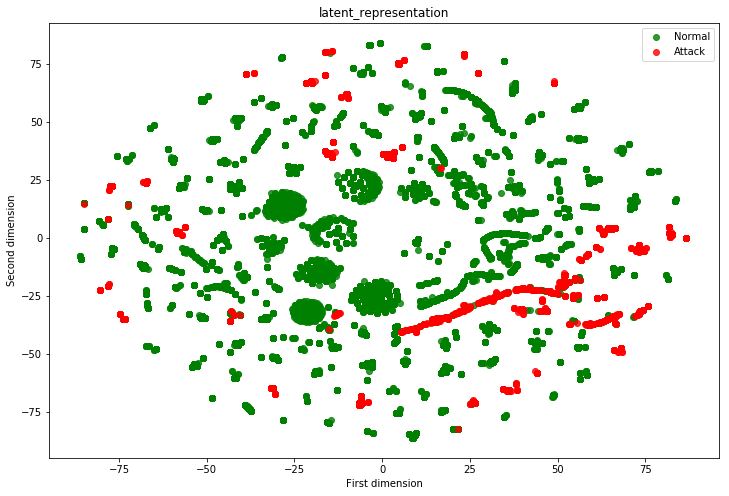

In [32]:
tsne_plot(hid_rep_v3, y_test, title = "latent_representation")


In [33]:
train_x, val_x, train_y, val_y = train_test_split(hid_rep_v3, y_test, test_size=0.2)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)


accuracy = accuracy_score(val_y, pred_y)
conf_mat = np.array(confusion_matrix(val_y, pred_y, labels=[0,1]))
confusion = pd.DataFrame(conf_mat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])

cl_report = classification_report(val_y, pred_y, target_names=['negative','positive'])

print ("accuracy score: {0:.2f}%".format(accuracy*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
print ("Classification Report\n")
print (cl_report)




accuracy score: 97.64%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                4383                  73
positive                  47                 577
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   negative       0.99      0.98      0.99      4456
   positive       0.89      0.92      0.91       624

avg / total       0.98      0.98      0.98      5080

